In [46]:
# imports
from datamodel import OrderDepth, UserId, TradingState, Order, Observation, ConversionObservation
from typing import List, Dict, Tuple, Any
import string
import json
import jsonpickle
import numpy as np
import math
from math import log, sqrt, exp
from dataclasses import dataclass
from statistics import NormalDist
import random
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
from collections import defaultdict

In [315]:
file_path = "/Users/vasudev/Desktop/Projects/imc_prosperity/prosperity-imc25/rounds/round5/eda/logs/aee35495-f1b4-4d7f-b855-268ab4a9a9ff.log"

In [316]:
@dataclass
class Trade:
    timestamp: int
    buyer: str
    seller: str
    symbol: str
    currency: str
    price: float
    quantity: int

def parse_logs(file_path: str) -> Tuple[str, pd.DataFrame, List[Any]]:
    # Read entire log file
    with open(file_path, 'r') as f:
        content = f.read()

    # --- Parse Sandbox Logs ---
    sandbox_start = content.find('Sandbox logs:')
    activities_start = content.find('Activities log:')
    sandbox_section = content[sandbox_start + len('Sandbox logs:'):activities_start].strip()

    # --- Parse Activities Log ---
    trades_start = content.find('Trade History:')
    activities_section = content[activities_start + len('Activities log:'):trades_start].strip()

    # Read CSV section into a DataFrame
    activities_df = pd.read_csv(StringIO(activities_section), sep=';')

    # --- Parse Trades ---
    trades_section = content[trades_start + len('Trade History:'):].strip()
    trades_data = json.loads(trades_section)

    # Convert to Trade objects
    trades: List[Any] = [Trade(**t) for t in trades_data]

    return sandbox_section, activities_df, trades

sandbox_section, activities_df, trades = parse_logs(file_path)

In [317]:
trades_df = pd.DataFrame([t.__dict__ for t in trades])
our_trades = [trade for trade in trades if trade.buyer == "SUBMISSION" or trade.seller == "SUBMISSION"]
our_trades_df = pd.DataFrame([trade.__dict__ for trade in our_trades])
print(len(our_trades_df))

331


In [318]:
# Sort the trades chronologically
our_trades_sorted = sorted(our_trades, key=lambda x: x.timestamp)

# Extract all unique timestamps and products from the activities dataframe
timestamps = sorted(activities_df['timestamp'].unique())
symbols = activities_df['product'].unique()

# Keep track of running position
running_pos = defaultdict(int)
records = []

# Pointer for iterating through our_trades_sorted
t_idx = 0

for t in timestamps:
    # Apply all trades that occurred at this timestamp
    while t_idx < len(our_trades_sorted) and our_trades_sorted[t_idx].timestamp == t:
        trade = our_trades_sorted[t_idx]
        if trade.buyer == "SUBMISSION":
            running_pos[trade.symbol] += trade.quantity
        elif trade.seller == "SUBMISSION":
            running_pos[trade.symbol] -= trade.quantity
        t_idx += 1

    # Record the position for all products at this timestamp
    for symbol in symbols:
        records.append({'timestamp': t, 'product': symbol, 'position': running_pos[symbol]})

# Create DataFrame of positions and merge
position_df = pd.DataFrame(records)
activities_df = activities_df.merge(position_df, on=['timestamp', 'product'], how='left')

# PRODUCT DICT

In [319]:
products = [
    "RAINFOREST_RESIN",
    "KELP", "SQUID_INK",
    "CROISSANTS", "JAMS",
    "DJEMBES", "PICNIC_BASKET1",
    "PICNIC_BASKET2",
    "VOLCANIC_ROCK",
    "VOLCANIC_ROCK_VOUCHER_9500", "VOLCANIC_ROCK_VOUCHER_9750",
    "VOLCANIC_ROCK_VOUCHER_10000", "VOLCANIC_ROCK_VOUCHER_10250",
    "VOLCANIC_ROCK_VOUCHER_10500", "MAGNIFICENT_MACARONS"
]

product_dict = {
    product: {
        "order_book": activities_df[activities_df['product'] == product],
        "trades": trades_df[trades_df['symbol'] == product]
    }
    for product in products
}
# check length of product_dict
print("Length of product_dict:", len(product_dict))

Length of product_dict: 15


# POSITIONS

In [320]:
product_dict["SQUID_INK"]["order_book"].head(10)

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss,position
0,4,0,SQUID_INK,1928.0,22.0,NaN,NaN,NaN,NaN,1931,2,1932.0,20.0,NaN,NaN,1929.5,0.0,0
18,4,100,SQUID_INK,1924.0,1.0,1923.0,27.0,NaN,NaN,1925,5,1927.0,28.0,NaN,NaN,1924.5,0.0,0
38,4,200,SQUID_INK,1927.0,24.0,NaN,NaN,NaN,NaN,1930,24,NaN,NaN,NaN,NaN,1928.5,0.0,0
46,4,300,SQUID_INK,1926.0,30.0,NaN,NaN,NaN,NaN,1929,30,NaN,NaN,NaN,NaN,1927.5,0.0,0
66,4,400,SQUID_INK,1927.0,20.0,NaN,NaN,NaN,NaN,1930,20,NaN,NaN,NaN,NaN,1928.5,0.0,0
89,4,500,SQUID_INK,1927.0,5.0,1925.0,29.0,NaN,NaN,1929,29,NaN,NaN,NaN,NaN,1928.0,0.0,0
91,4,600,SQUID_INK,1926.0,24.0,NaN,NaN,NaN,NaN,1929,24,NaN,NaN,NaN,NaN,1927.5,0.0,0
112,4,700,SQUID_INK,1931.0,4.0,1929.0,31.0,NaN,NaN,1932,31,NaN,NaN,NaN,NaN,1931.5,0.0,0
121,4,800,SQUID_INK,1934.0,23.0,NaN,NaN,NaN,NaN,1937,23,NaN,NaN,NaN,NaN,1935.5,0.0,0
138,4,900,SQUID_INK,1936.0,21.0,NaN,NaN,NaN,NaN,1940,21,NaN,NaN,NaN,NaN,1938.0,0.0,0


In [321]:
voucher_products = [
    "VOLCANIC_ROCK_VOUCHER_9500", "VOLCANIC_ROCK_VOUCHER_9750",
    "VOLCANIC_ROCK_VOUCHER_10000", "VOLCANIC_ROCK_VOUCHER_10250",
    "VOLCANIC_ROCK_VOUCHER_10500"
]

voucher_positions = position_df[position_df['product'].isin(voucher_products)]
voucher_positions.head(50)

,timestamp,product,position
3,0,VOLCANIC_ROCK_VOUCHER_10000,0
5,0,VOLCANIC_ROCK_VOUCHER_10250,0
7,0,VOLCANIC_ROCK_VOUCHER_10500,0
8,0,VOLCANIC_ROCK_VOUCHER_9750,0
11,0,VOLCANIC_ROCK_VOUCHER_9500,0
18,100,VOLCANIC_ROCK_VOUCHER_10000,0
20,100,VOLCANIC_ROCK_VOUCHER_10250,0
22,100,VOLCANIC_ROCK_VOUCHER_10500,0
23,100,VOLCANIC_ROCK_VOUCHER_9750,0
26,100,VOLCANIC_ROCK_VOUCHER_9500,0


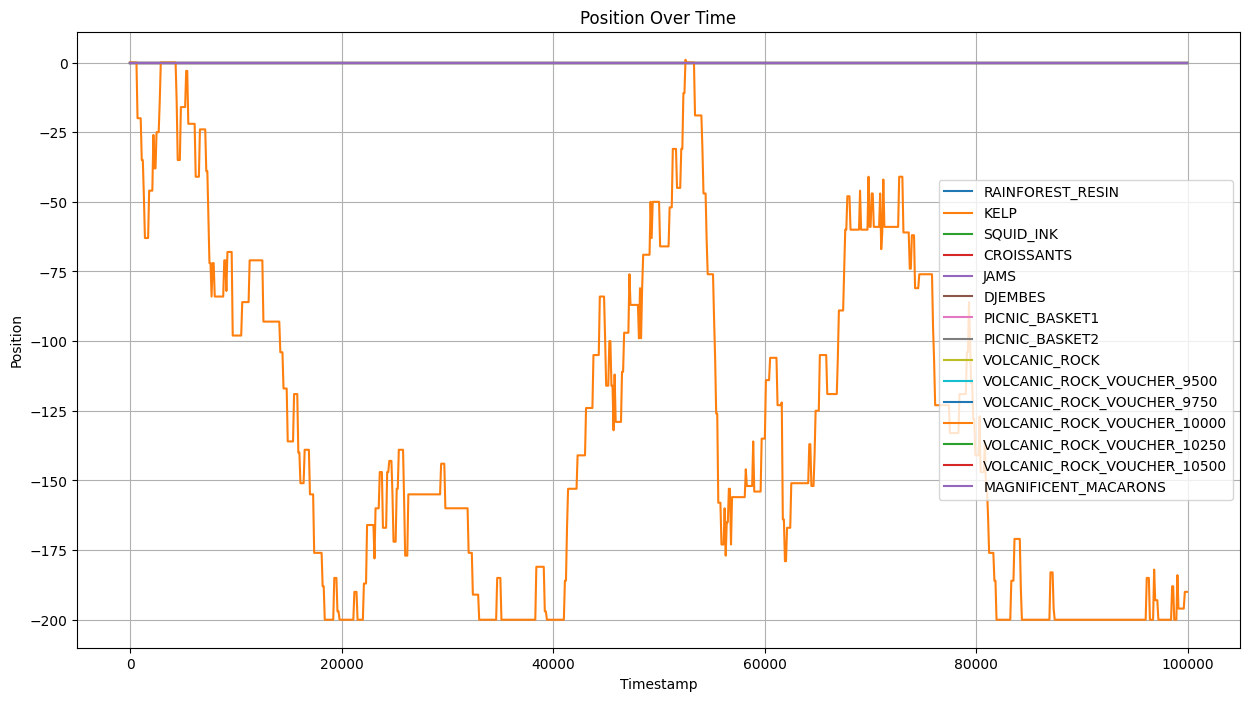

In [322]:
plt.figure(figsize=(15, 8))

for product, dict in product_dict.items():
    # Plot position
    plt.plot(dict['order_book']['timestamp'], dict['order_book']['position'], label=product)
    plt.xlabel('Timestamp')
    plt.ylabel('Position')
    plt.title('Position Over Time')
    plt.legend()
    plt.grid()


# PNL

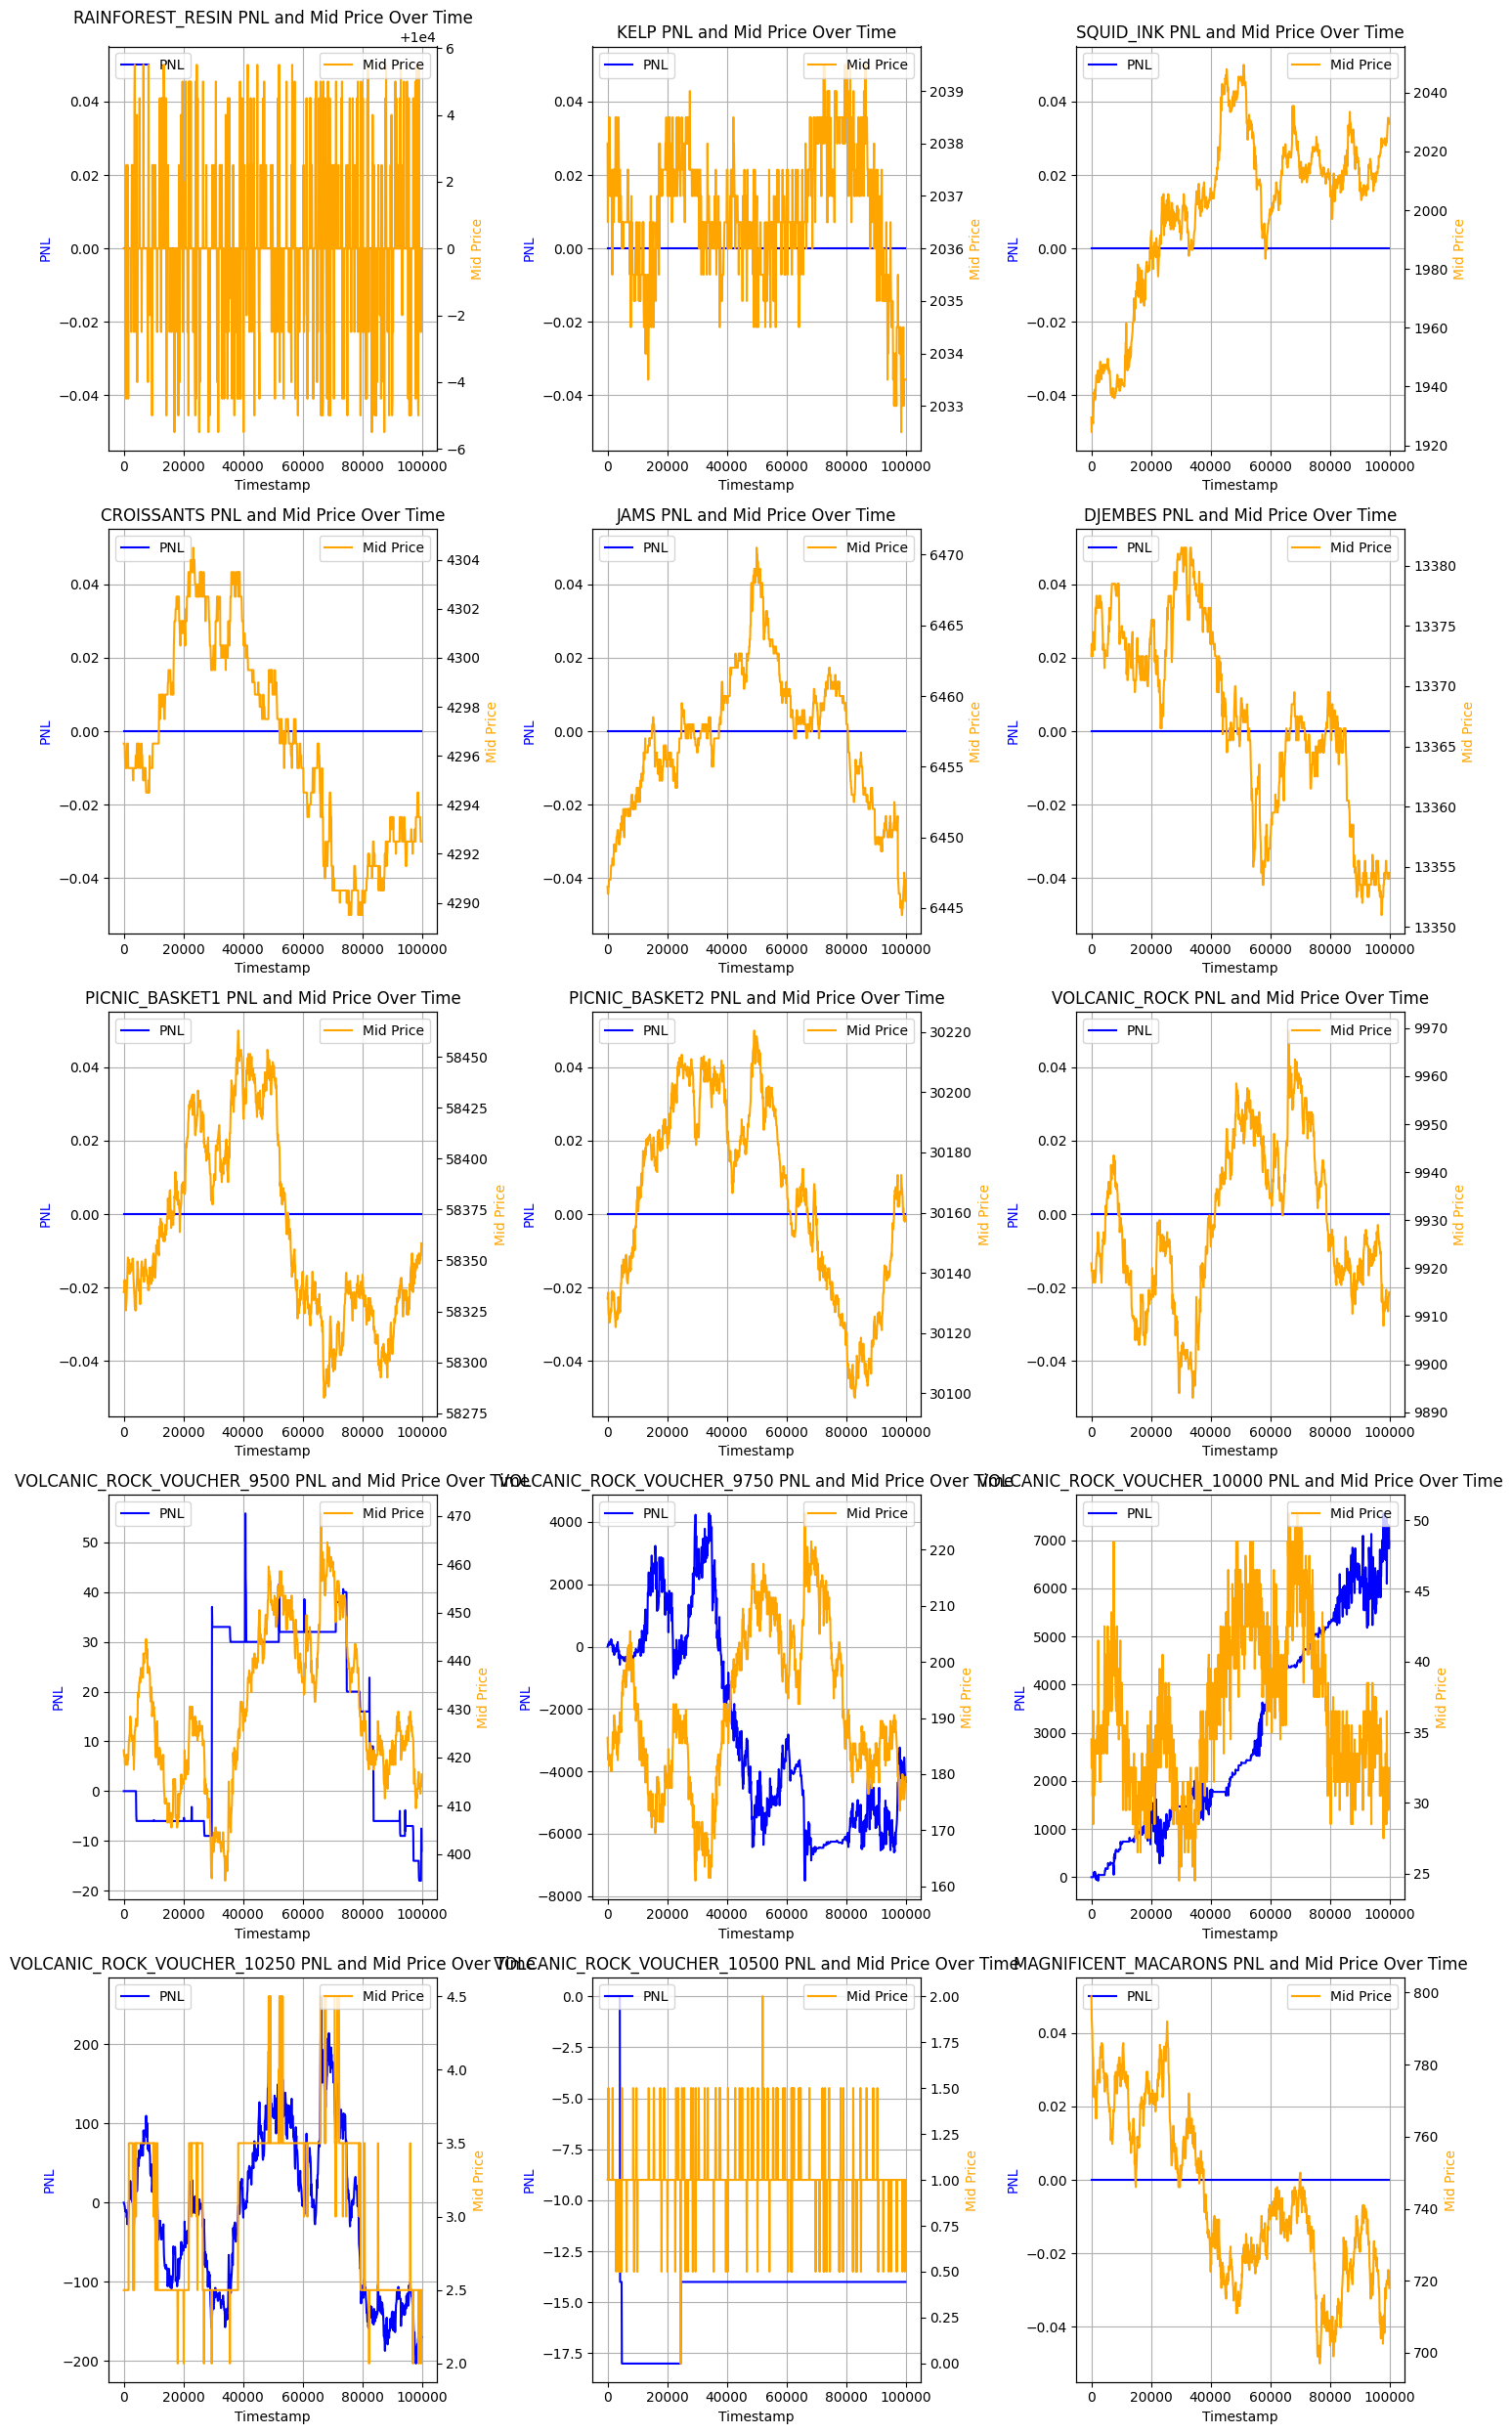

In [306]:
# Determine the number of products and grid size
num_products = len(product_dict)
cols = 3  # Number of columns in the grid
rows = (num_products + cols - 1) // cols  # Calculate rows needed

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Plot each product's PnL and mid price in a subplot
for i, (product, data) in enumerate(product_dict.items()):
    ax = axes[i]
    if 'profit_and_loss' in data['order_book'].columns and 'mid_price' in data['order_book'].columns:
        ax.plot(data['order_book']['timestamp'], data['order_book']['profit_and_loss'], label='PNL', color='blue')
        ax.set_title(f'{product} PNL and Mid Price Over Time')
        ax.set_xlabel('Timestamp')
        ax.set_ylabel('PNL', color='blue')
        ax.grid()
        ax.legend(loc='upper left')

        # Create a secondary y-axis for mid price
        ax2 = ax.twinx()
        ax2.plot(data['order_book']['timestamp'], data['order_book']['mid_price'], label='Mid Price', color='orange')
        ax2.set_ylabel('Mid Price', color='orange')
        ax2.legend(loc='upper right')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# VOLCANIC ROCK POSITIONS

In [277]:
def bisection_iv(
        S: float,
        V: float,
        K: int,
        TTT: float,
        low: float = 1e-4,
        high: float = 1.0,
        tol: float = 1e-4,
        max_iter: int = 10
) -> Tuple[float, float]:
    """
    Bisection method to find the implied volatility and delta.
    """
    N = NormalDist()
    for _ in range(max_iter):
        iv = (low + high) / 2
        d1 = (log(S / K) + (0.5 * high**2) * TTT) / (high * sqrt(TTT))
        d2 = d1 - high * sqrt(TTT)
        delta = N.cdf(d1)
        price = S * delta - K * N.cdf(d2)
        if abs(price - V) < tol:
            return iv, delta
        if price > V:
            high = iv
        else:
            low = iv
    return iv, delta

def newton_iv(
        S: float,
        V: float,
        K: int,
        TTE: float,
        iv: float = 0.2,
        tol: float = 1e-4,
        max_iter: int = 50
) -> Tuple[float, float]:
    """
    Newton's method to find the implied volatility and delta.
    """
    N = NormalDist()
    for _ in range(max_iter):
        d1 = (log(S / K) + (0.5 * iv**2) * TTE) / (iv * sqrt(TTE))
        d2 = d1 - iv * sqrt(TTE)
        delta = N.cdf(d1)
        price = S * delta - K * N.cdf(d2)
        vega = S * N.pdf(d1) * sqrt(TTE)
        if vega < 1e-5:
            return bisection_iv(S, V, K, TTE, low=1e-4, high=1.0, tol=tol)
        iv -= (price - V) / vega
        if abs(price - V) < tol:
            return iv, delta
    return iv, delta

def black_scholes_price(
        S: float,
        K: int,
        TTE: float,
        iv: float,
        r: float = 0.0
) -> float:
    """
    Calculate the Black-Scholes price.
    """
    N = NormalDist()
    d1 = (log(S / K) + (0.5 * iv**2) * TTE) / (iv * sqrt(TTE))
    d2 = d1 - iv * sqrt(TTE)
    call_price = S * N.cdf(d1) - K * exp(-r * TTE) * N.cdf(d2)
    return call_price


def add_volcanic_rock_metrics(df: pd.DataFrame) -> pd.DataFrame:
    """
    For each row in df (with columns 'timestamp' and 'mid_price'), compute:
      - iv_{strike}, delta_{strike}
      - moneyness_{strike}
      - iv_fit_{strike}, misvol_{strike}, fair_{strike}
    for strikes = [9500, 9750, 10000, 10250, 10500], and append all as new cols.
    """
    strikes = [9500, 9750, 10000, 10250, 10500]
    
    def compute_row(row):
        S = row['mid_price']
        TTE = (3e6 - row['timestamp']) / (1e6 * 365)
        out = {}
        # 1) raw IV + delta + moneyness
        for K in strikes:
            # assume you've pre–merged in the voucher mid‐prices as e.g. mid_price_9500, etc.
            V = row[f'mid_price_{K}']
            iv, delta = newton_iv(S, V, K, TTE)
            m = np.log(K / S) / np.sqrt(TTE)
            out[f'iv_{K}'] = iv
            out[f'delta_{K}'] = delta
            out[f'moneyness_{K}'] = m
        
        # 2) fit a quadratic IV curve
        m_vals = [out[f'moneyness_{K}'] for K in strikes]
        iv_vals = [out[f'iv_{K}'] for K in strikes]
        a, b, c = np.polyfit(m_vals, iv_vals, 2)
        
        # 3) iv_fit, misvol, fair
        for K in strikes:
            m = out[f'moneyness_{K}']
            iv_fit = a*m*m + b*m + c
            fair = black_scholes_price(S, K, TTE, iv_fit)
            out[f'iv_fit_{K}']  = iv_fit
            out[f'misvol_{K}']  = out[f'iv_{K}'] - iv_fit
            out[f'fair_{K}']    = fair
        
        return pd.Series(out)
    
    # apply row‐wise and concat
    metrics = df.apply(compute_row, axis=1)
    return pd.concat([df, metrics], axis=1)

volcanic_rock_df = product_dict["VOLCANIC_ROCK"]["order_book"].copy()

for K in [9500, 9750, 10000, 10250, 10500]:
    voucher_df = product_dict[f"VOLCANIC_ROCK_VOUCHER_{K}"]["order_book"]
    volcanic_rock_df[f'mid_price_{K}'] = voucher_df['mid_price'].values

volcanic_rock_df = volcanic_rock_df.copy()

volcanic_rock_df = add_volcanic_rock_metrics(volcanic_rock_df)

# for each strike print a summary of fair price and mid price
for K in [9500, 9750, 10000, 10250, 10500]:
    print(f"Strike {K}:")
    print(volcanic_rock_df[[f'mid_price_{K}', f'fair_{K}']].describe())

Strike 9500:
       mid_price_9500    fair_9500
count      1000.00000  1000.000000
mean        429.98500   430.055462
std          16.01472    15.995545
min         394.50000   394.584826
25%         418.50000   418.661739
50%         427.50000   427.494192
75%         441.50000   441.627404
max         470.50000   470.470427
Strike 9750:
       mid_price_9750    fair_9750
count     1000.000000  1000.000000
mean       191.541500   190.639268
std         14.073738    14.169021
min        161.000000   160.654101
25%        181.500000   180.517183
50%        188.500000   188.145482
75%        202.500000   201.387931
max        226.500000   227.005401
Strike 10000:
       mid_price_10000   fair_10000
count      1000.000000  1000.000000
mean         36.485500    35.851326
std           5.445291     5.432199
min          24.500000    25.072434
25%          32.500000    31.510947
50%          35.500000    35.152049
75%          40.500000    40.055155
max          50.500000    49.802956
Strike

Strike 9500:
  Average difference: -0.07046162290901156
  Standard deviation: 0.06621541425907182
  5th percentile: -0.1721987238744987 (Adjusted: -0.24266034678351026)
  95th percentile: 0.03539333487224211 (Adjusted: -0.03506828803676945)
  Difference between average and 5th percentile: 0.10173710096548713
  Difference between average and 95th percentile: -0.10585495778125367


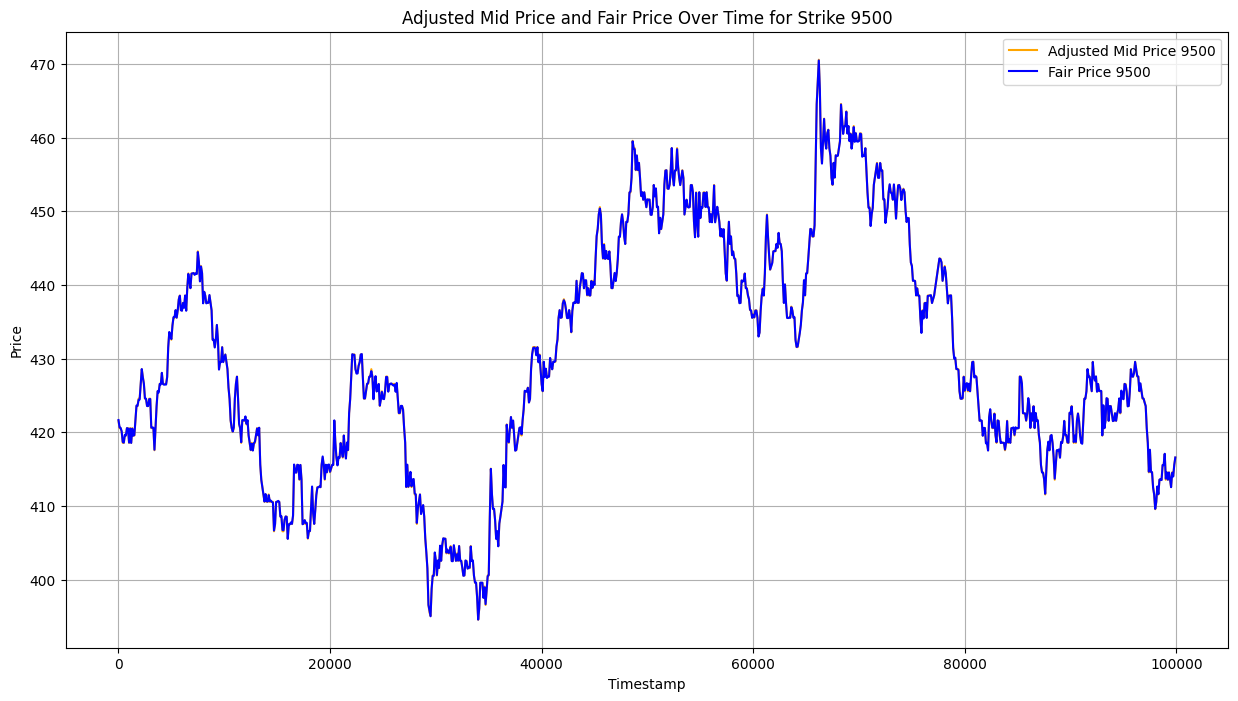

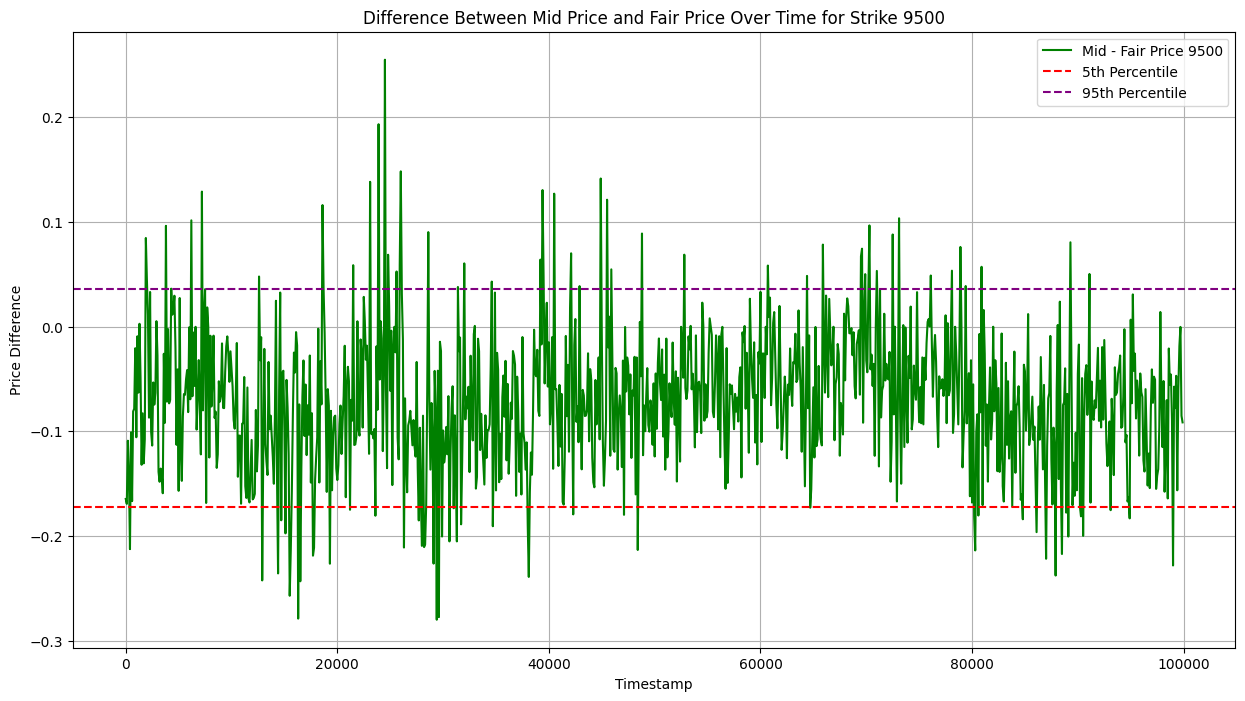

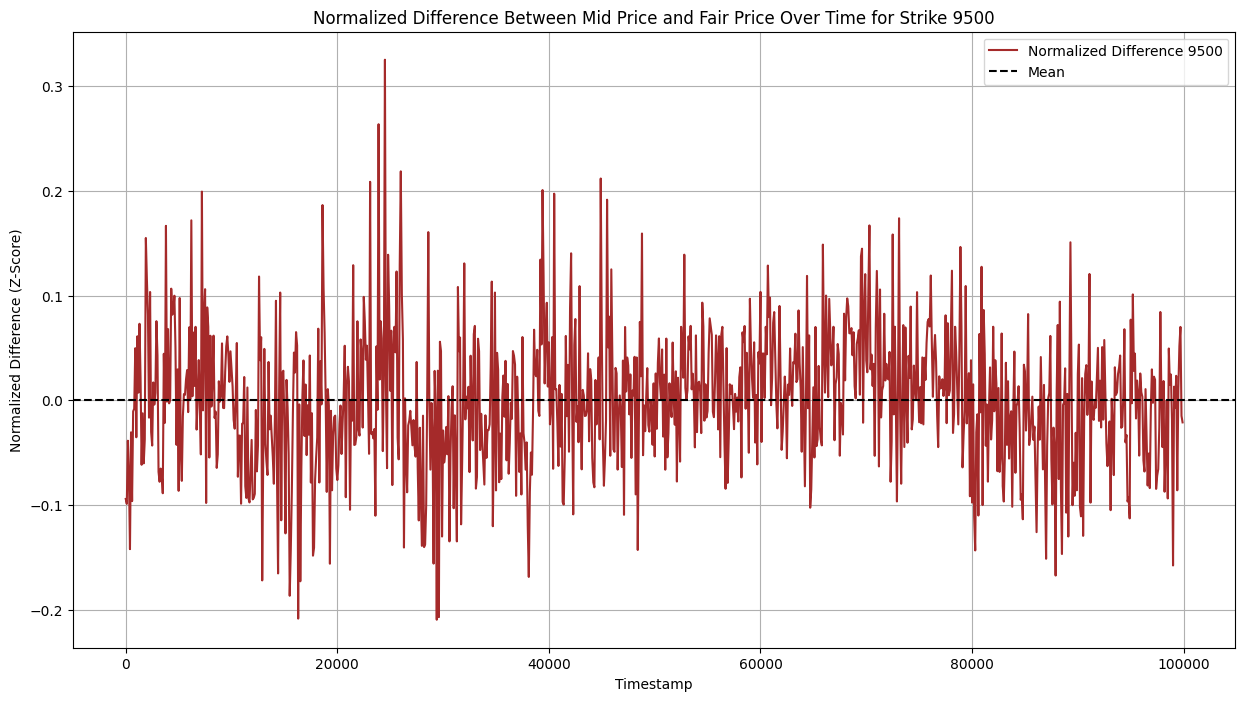

Strike 9750:
  Average difference: 0.9022322466765381
  Standard deviation: 1.1575636425831433
  5th percentile: -0.862907987338167 (Adjusted: 0.03932425933837114)
  95th percentile: 2.8153573744801172 (Adjusted: 3.7175896211566553)
  Difference between average and 5th percentile: 1.765140234014705
  Difference between average and 95th percentile: -1.9131251278035792


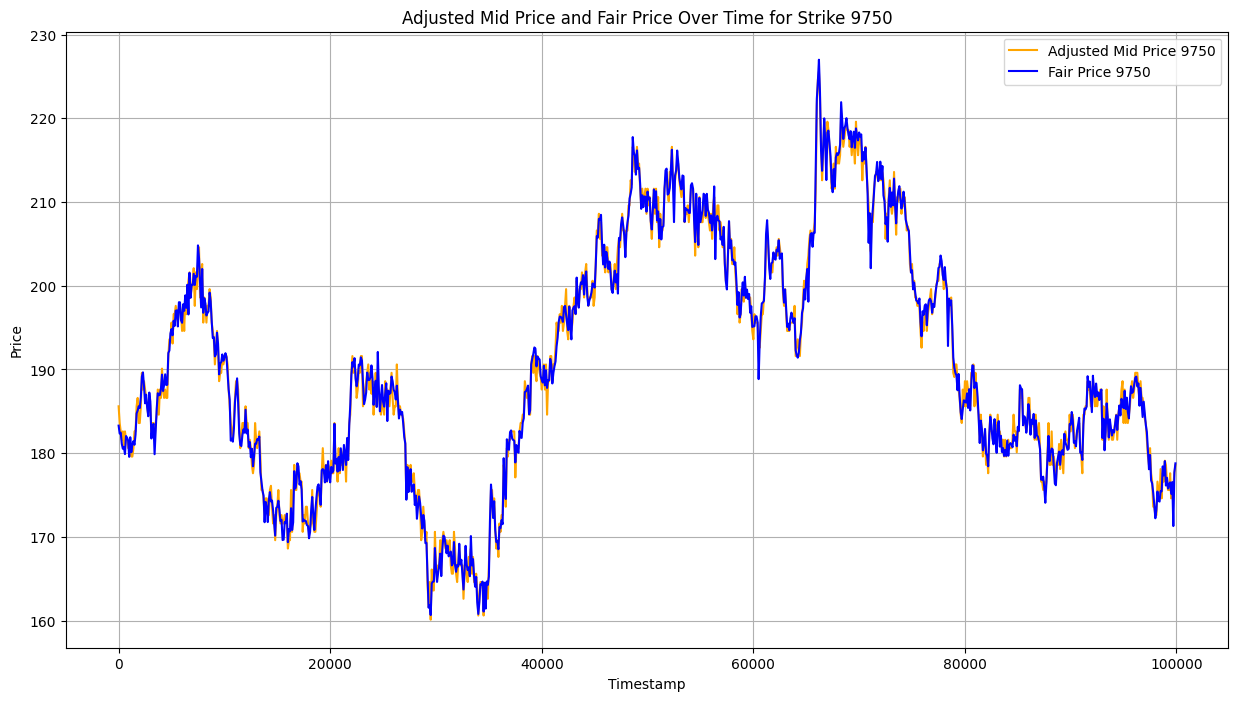

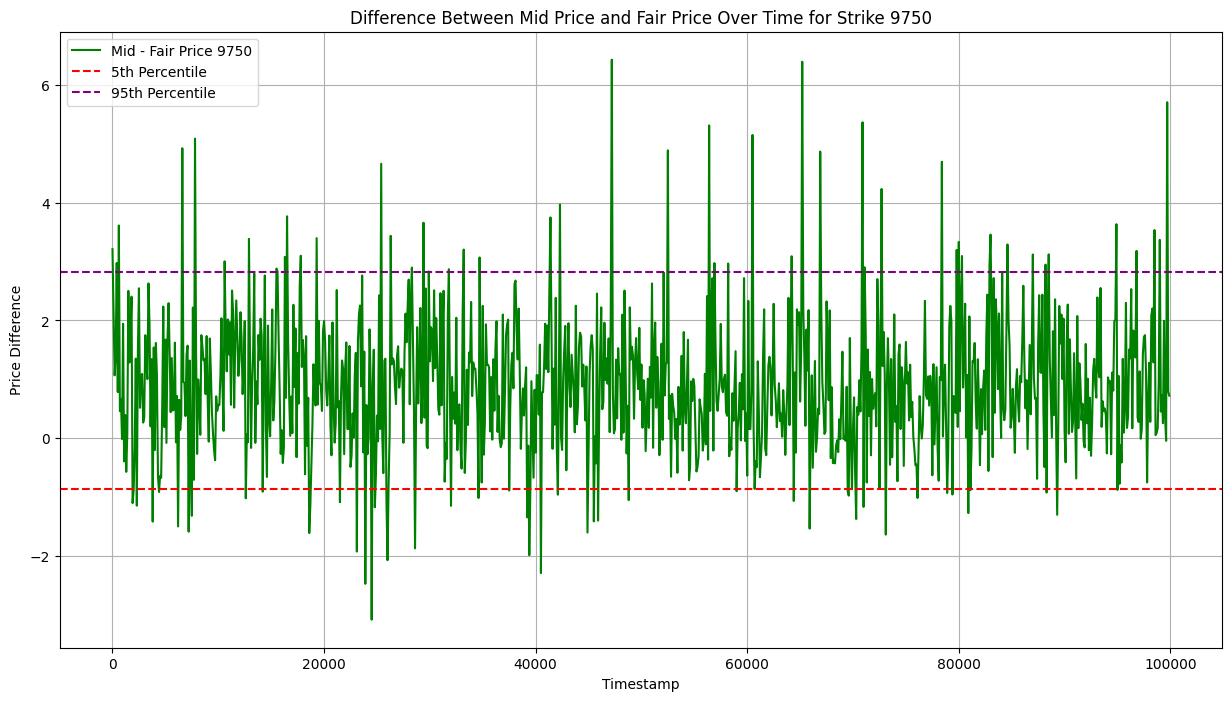

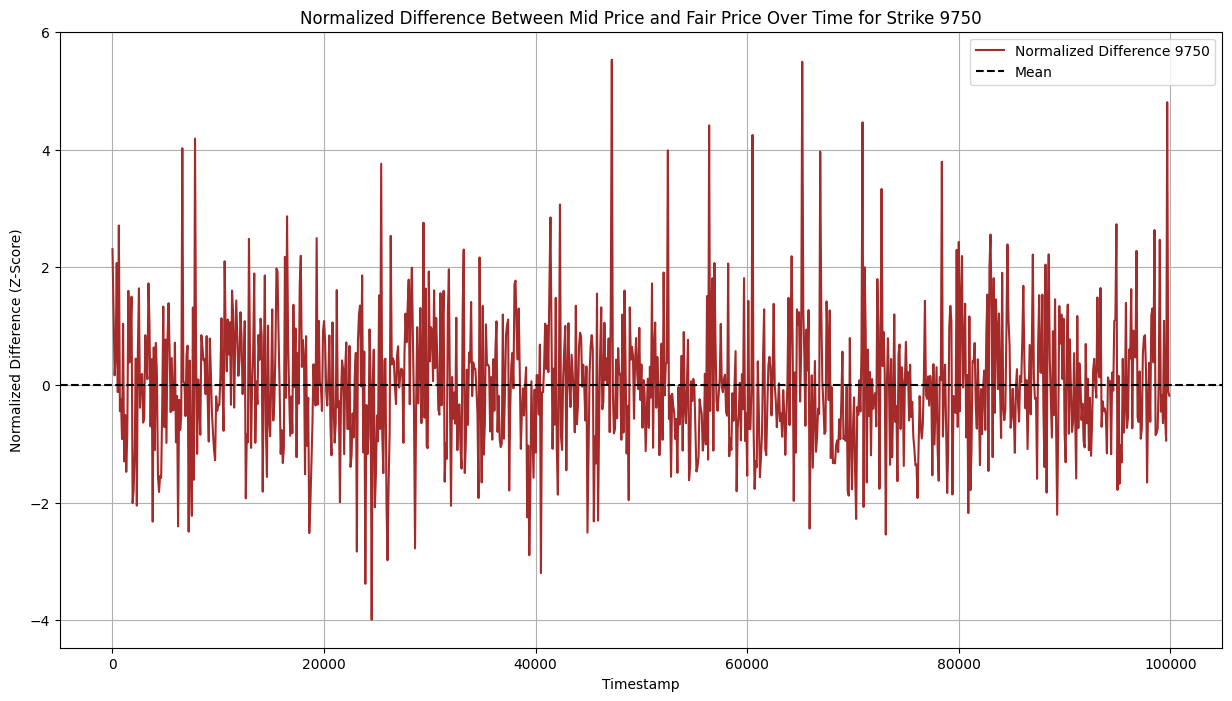

Strike 10000:
  Average difference: 0.6341742643326724
  Standard deviation: 1.407143708277258
  5th percentile: -1.6621397127447834 (Adjusted: -1.027965448412111)
  95th percentile: 2.802338171072506 (Adjusted: 3.4365124354051786)
  Difference between average and 5th percentile: 2.296313977077456
  Difference between average and 95th percentile: -2.1681639067398337


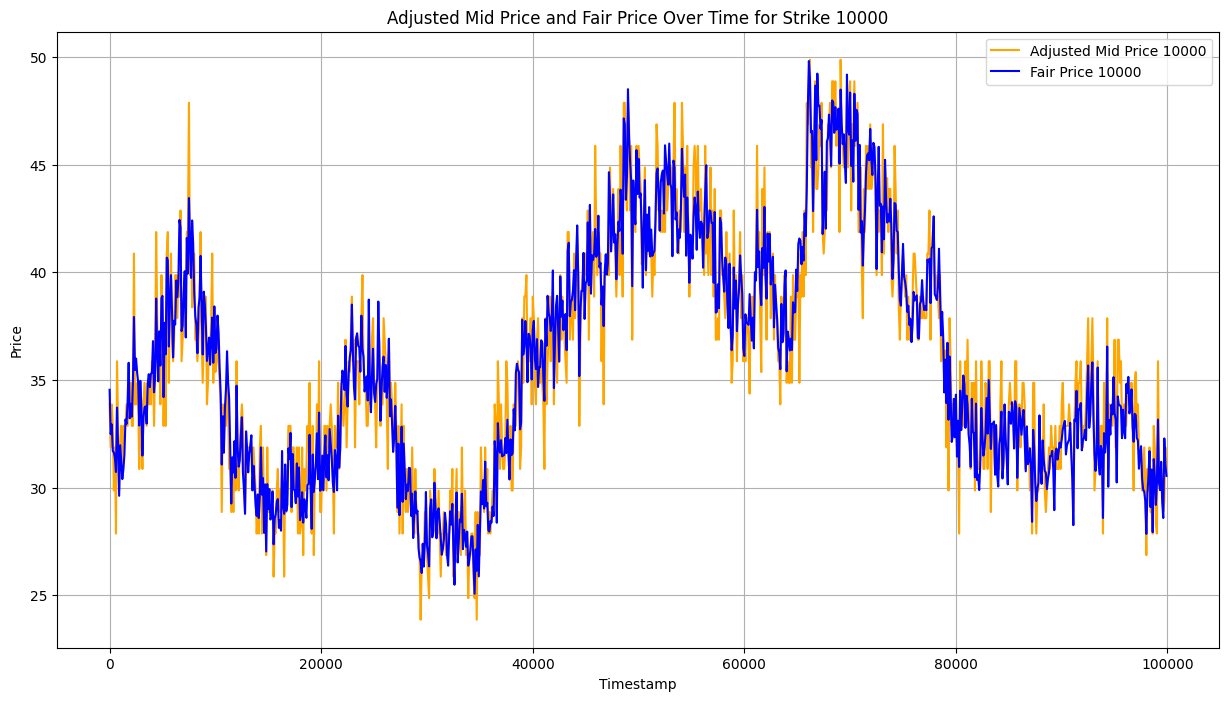

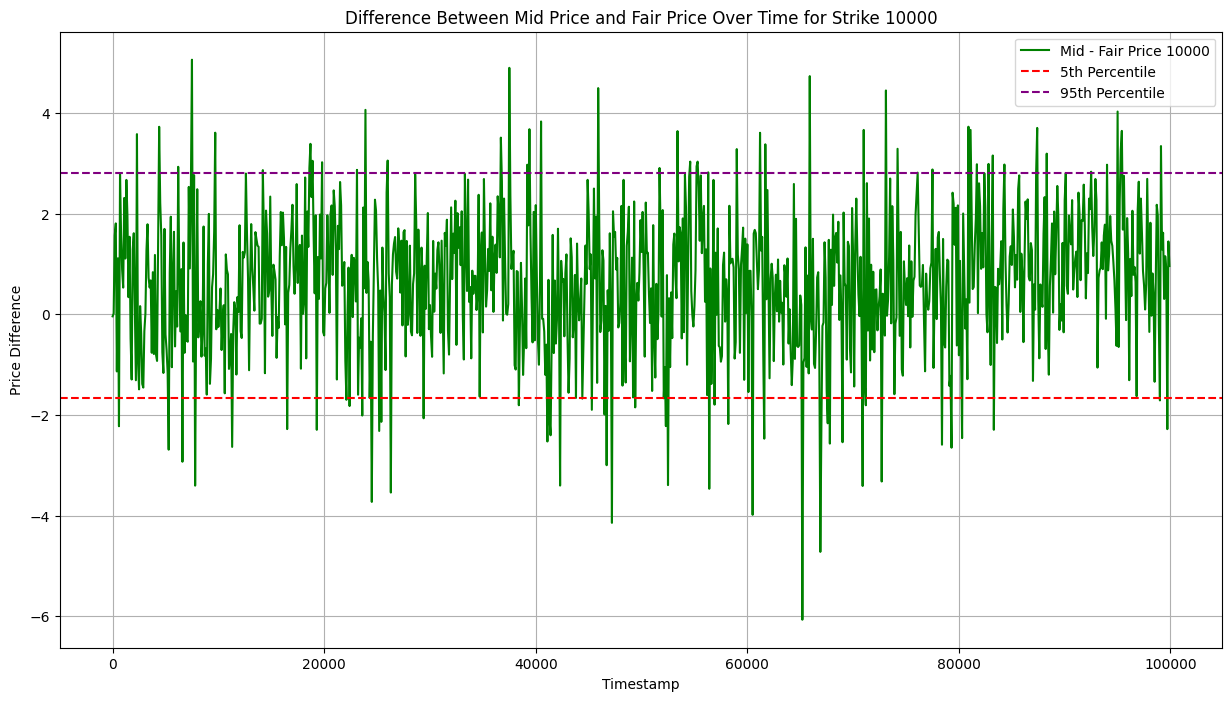

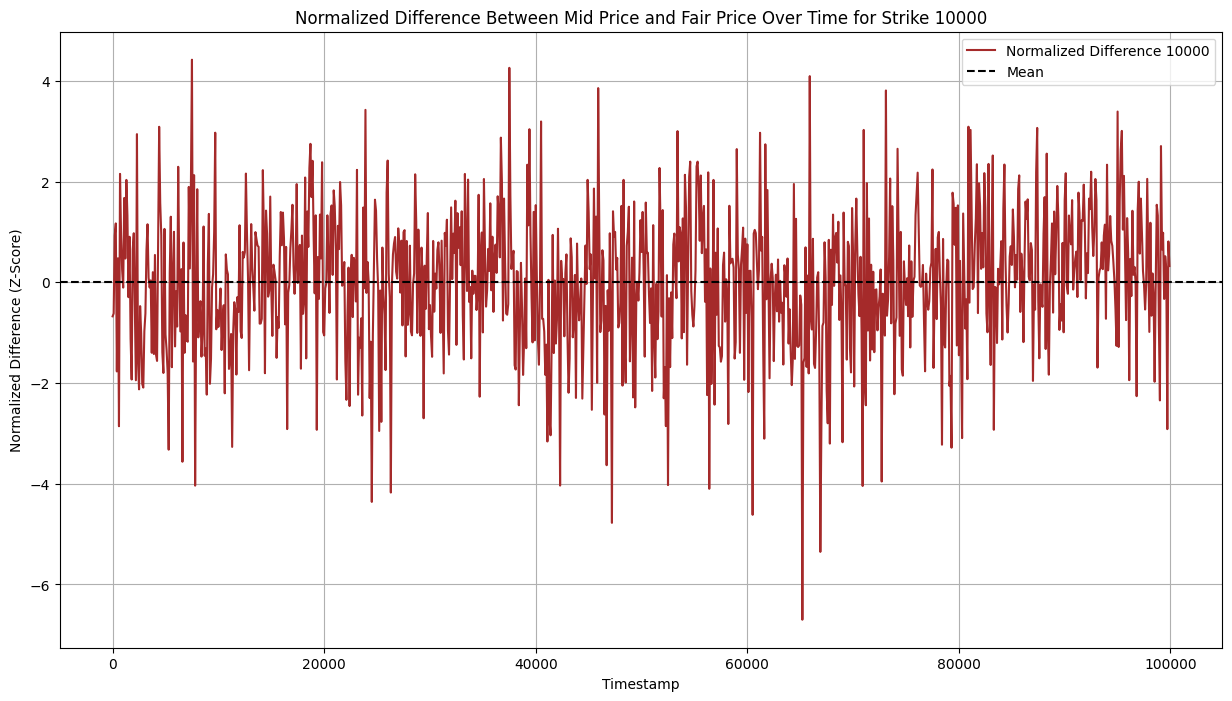

Strike 10250:
  Average difference: -0.6234363644506203
  Standard deviation: 0.3674667992435049
  5th percentile: -1.172677169389209 (Adjusted: -1.7961135338398293)
  95th percentile: -0.09281406076124493 (Adjusted: -0.7162504252118653)
  Difference between average and 5th percentile: 0.5492408049385887
  Difference between average and 95th percentile: -0.5306223036893754


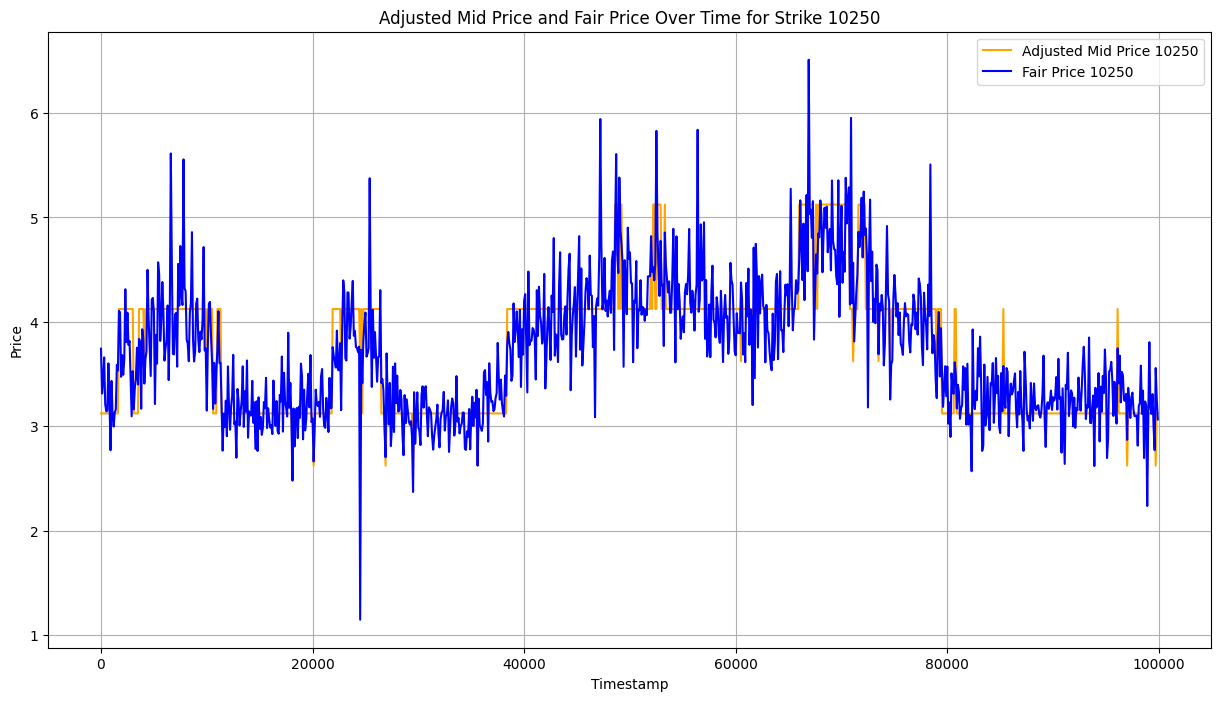

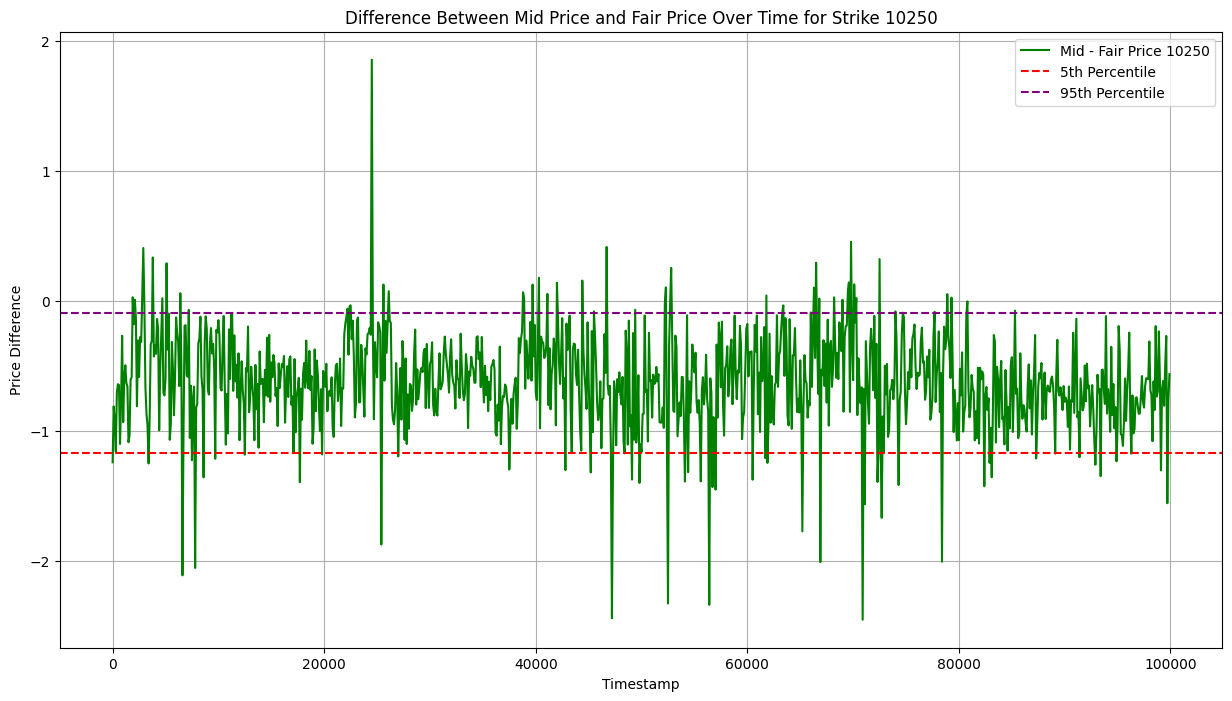

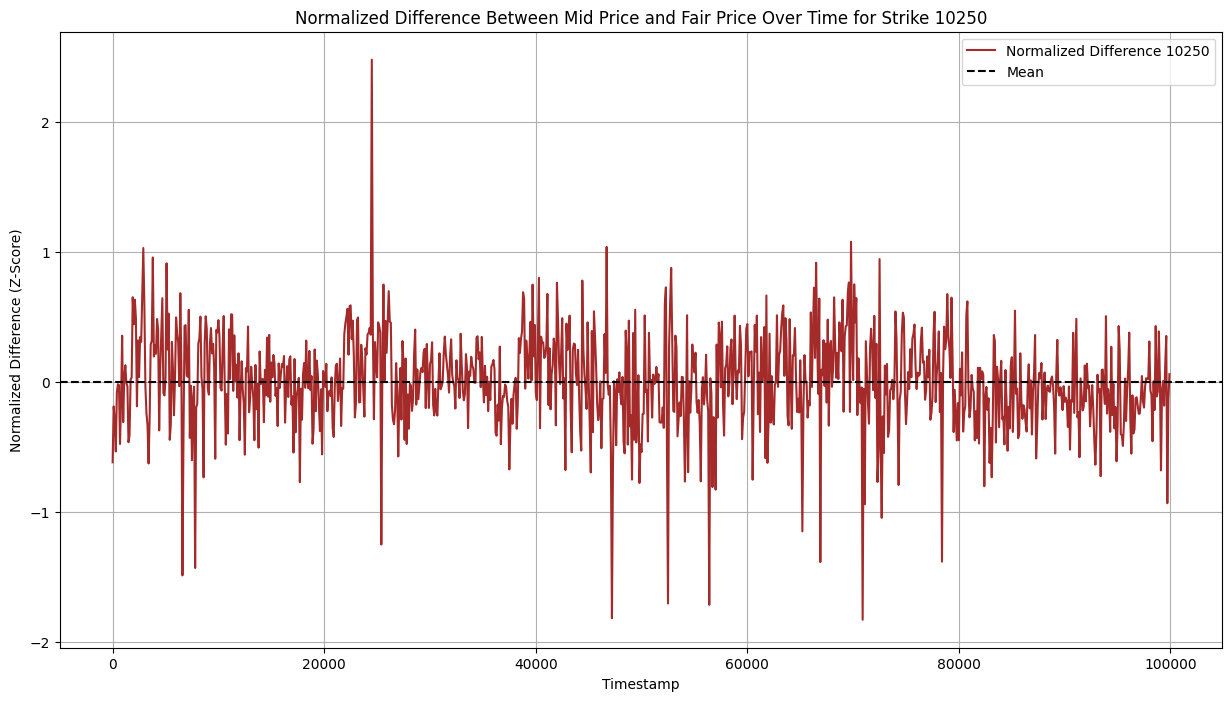

Strike 10500:
  Average difference: 0.09433258048621344
  Standard deviation: 0.056768960587535396
  5th percentile: 0.00847277330554661 (Adjusted: 0.10280535379176005)
  95th percentile: 0.18978613456925827 (Adjusted: 0.2841187150554717)
  Difference between average and 5th percentile: 0.08585980718066684
  Difference between average and 95th percentile: -0.09545355408304483


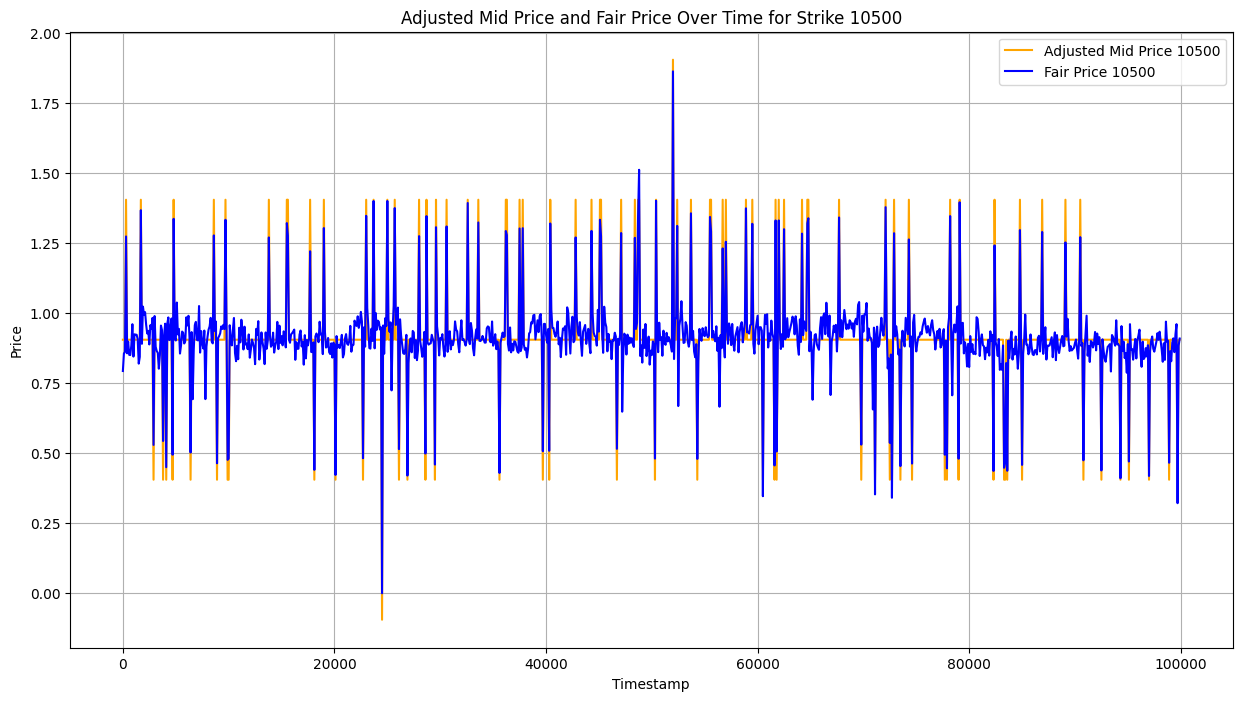

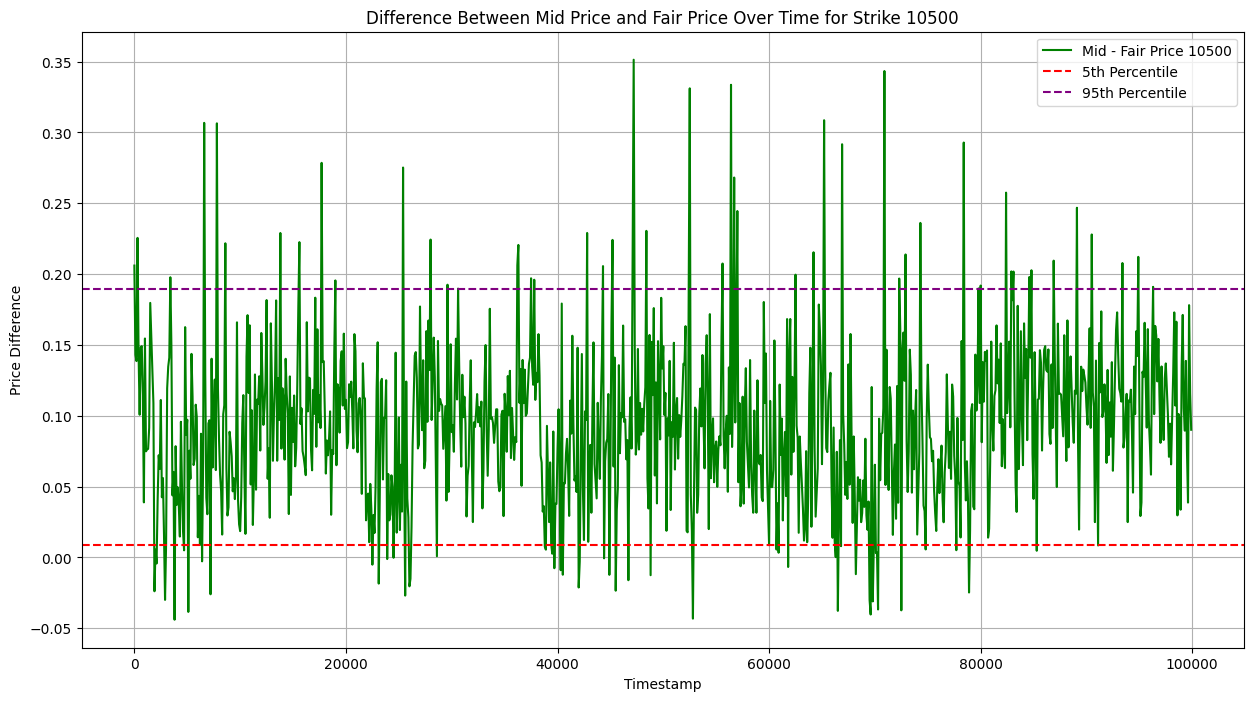

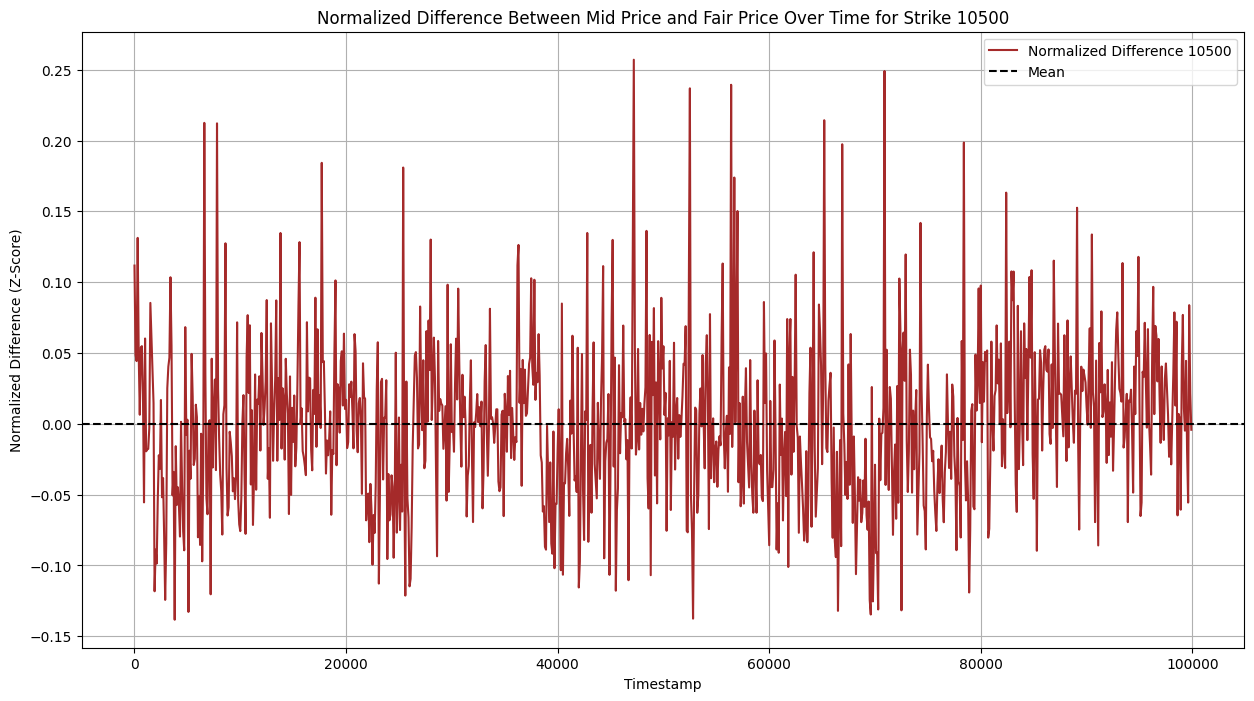

In [279]:
for K in [9500, 9750, 10000, 10250, 10500]:
    price_diff = volcanic_rock_df[f'mid_price_{K}'] - volcanic_rock_df[f'fair_{K}']
    avg_diff = price_diff.mean()
    std_diff = price_diff.std()
    percentile_5 = price_diff.quantile(0.05)
    percentile_95 = price_diff.quantile(0.95)
    
    # Normalize the difference (z-score)
    normalized_diff = (price_diff - avg_diff)
    
    print(f"Strike {K}:")
    print(f"  Average difference: {avg_diff}")
    print(f"  Standard deviation: {std_diff}")
    print(f"  5th percentile: {percentile_5} (Adjusted: {percentile_5 + avg_diff})")
    print(f"  95th percentile: {percentile_95} (Adjusted: {percentile_95 + avg_diff})")
    print(f"  Difference between average and 5th percentile: {avg_diff - percentile_5}")
    print(f"  Difference between average and 95th percentile: {avg_diff - percentile_95}")
    
    # Plot mid price (adjusted) and fair value
    plt.figure(figsize=(15, 8))
    plt.plot(volcanic_rock_df['timestamp'], volcanic_rock_df[f'mid_price_{K}'] - avg_diff, label=f'Adjusted Mid Price {K}', color='orange')
    plt.plot(volcanic_rock_df['timestamp'], volcanic_rock_df[f'fair_{K}'], label=f'Fair Price {K}', color='blue')
    plt.xlabel('Timestamp')
    plt.ylabel('Price')
    plt.title(f'Adjusted Mid Price and Fair Price Over Time for Strike {K}')
    plt.legend()
    plt.grid()
    plt.show()
    
    # Plot the difference
    plt.figure(figsize=(15, 8))
    plt.plot(volcanic_rock_df['timestamp'], price_diff, label=f'Mid - Fair Price {K}', color='green')
    plt.axhline(percentile_5, color='red', linestyle='--', label='5th Percentile')
    plt.axhline(percentile_95, color='purple', linestyle='--', label='95th Percentile')
    plt.xlabel('Timestamp')
    plt.ylabel('Price Difference')
    plt.title(f'Difference Between Mid Price and Fair Price Over Time for Strike {K}')
    plt.legend()
    plt.grid()
    plt.show()
    
    # Plot the normalized difference
    plt.figure(figsize=(15, 8))
    plt.plot(volcanic_rock_df['timestamp'], normalized_diff, label=f'Normalized Difference {K}', color='brown')
    plt.axhline(0, color='black', linestyle='--', label='Mean')
    plt.xlabel('Timestamp')
    plt.ylabel('Normalized Difference (Z-Score)')
    plt.title(f'Normalized Difference Between Mid Price and Fair Price Over Time for Strike {K}')
    plt.legend()
    plt.grid()
    plt.show()